# Predicting Breast Cancer Recurrence Using Machine Learning

## Introduction

Breast cancer is one of the most common cancers among women, making it essential to understand the factors that contribute to its recurrence to improve patient prognosis and survival rate. By integrating predictive models into clinical practice, healthcare providers can provide effective, targeted intervention for high-risk patients. This analysis seeks to accomplish two main goals. First, it explores how predictive models can be used to accurately predict the recurrence of breast cancer based on attributes such as patient demographics and clinical features. Second, it seeks is to identify which factors are most important for predicting recurrence.

## Dataset

The dataset used in this analysis is sourced from UCI Machine Learning Repository and originally comes from University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. Please see the following link for more information: https://archive.ics.uci.edu/dataset/14/breast+cancer. It includes the target variable ('Class') indicating recurrence/ no recurrence, along with nine attributes related to patient demographics, clinical features and treatment. To provide a clearer understanding of these features, we will briefly describe each one below.

### Feature Information:

1. _Class_: Indicates whether the patient experienced recurrence events of breast cancer
2. _Age_: Indicates the age of the patient
3. _Menopause_: Indiates the menopausal stage of the patient (premenopausal vs postmenopausal)
4. _Tumor size_: Indicates the size of the tumor in millimeters
5. _Inv-nodes_: Refers to the number of positive lymph nodes that contain cancer
6. _Node-caps_: Refer to the presence of extracapsular extension which means that cancer cells have spread beyond the capusle of the lymph node into surrounding tissue
7. _Degree-malig_: Indicates how aggressive the cancerous tumor is
8. _Breast_: Refers to the side (left or right) where cancer has occurred  
9. _Breast-quad_: Identifys the specific quadrant of the breast where tumor is located
10. _Irradiat_: Indicates whether patient has received radiation therapy

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Reading in the data
data_file_path = 'data/breast-cancer.data'
df = pd.read_csv(data_file_path, header=None)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [4]:
# Feature names
feature_names = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

In [5]:
# Populate columns with feature names
df = df.rename(columns = dict(zip(df.columns, feature_names)))

In [6]:
df.shape

(286, 10)

**Observations:**
- There are 286 samples and 10 features, which is a relatively small dataset
- This could limit the model's ability to effectively learn and generalize well to unseen data

In [7]:
df.head(5)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


## Dataset Overview

#### 1. Get an overview of dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


**Observations:**
- All columns have 286 non-null counts indicating there are no missing values 
- Every column is of type object except for deg-malig, indicating these are categorical features. These categories will likely need to be encoded before training the models

#### 2. Confirm no missing values

In [9]:
df.isnull().sum()

Class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

**Observations:**
- There are no missing values

## Exploratory Data Analysis

#### 1. View Distribution of Target Variable

We start by examing the distribution of the target variable ('Class'). This step is crucial for identifying any class imbalance, which can significantly impact a model's performance.

In [10]:
## Different class in target variable 'Class'
df['Class'].value_counts()

no-recurrence-events    201
recurrence-events        85
Name: Class, dtype: int64

In [11]:
## Convert distribution of target variable into percentages which makes its easier to quantify distribution 
percentage = df['Class'].value_counts(normalize = True)*100
percentage

no-recurrence-events    70.27972
recurrence-events       29.72028
Name: Class, dtype: float64

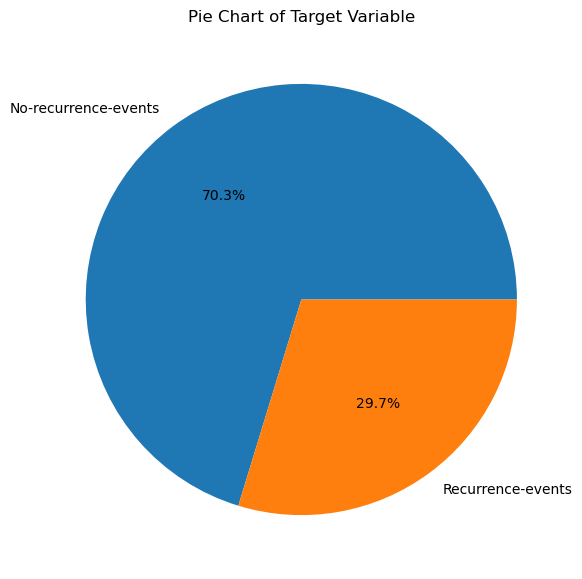

In [12]:
# Visualizing distribution with pie chart
classlabels = ["No-recurrence-events", "Recurrence-events"]
plt.figure(figsize=(12,7))
plt.pie(percentage, labels = classlabels, autopct='%1.1f%%')
plt.title("Pie Chart of Target Variable")
plt.show()

**Observations:**
- These is significant class imbalance with ~70% belonging to 'No recurrence event' and ~30% to 'recurrence event' class
- One potential issue with class imbalanace is that the models trained on this dataset can become **biased towards the majority class (no recurrent event)**. 

In [13]:
# Convert target variable to numerical values. Replace Class categories with 0, 1
df['Class'] = np.where(df['Class'] == 'no-recurrence-events', 0 , 1)

In [14]:
# Verify conversion worked properly
df['Class'].value_counts(normalize = True)*100

0    70.27972
1    29.72028
Name: Class, dtype: float64

#### 2. Univariate Analysis

Now we will proceed to visualize and analyze the distribution of each respective feature. We first define two lists: one for numeric features and one for categorical features.

In [15]:
# Define numerical and categorical columns using list comprehension
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O' and feature != 'Class']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

In [16]:
print("Numeric Features: ", numeric_features)
print("Categorical Features: ", categorical_features)

Numeric Features:  ['deg-malig']
Categorical Features:  ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiat']


2a. Univariate analysis for categorical features:

Feature: age
       count percentage
50-59     96      33.6%
40-49     90      31.5%
60-69     57      19.9%
30-39     36      12.6%
70-79      6       2.1%
20-29      1       0.3% 




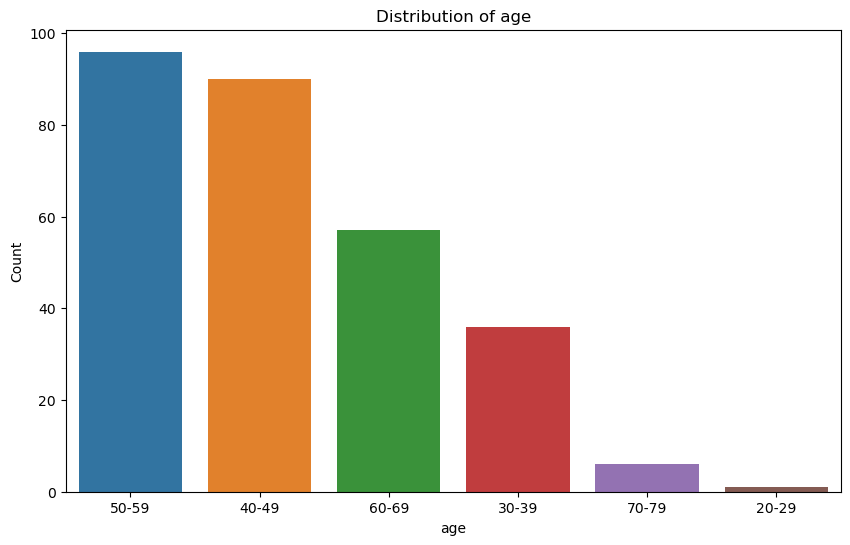

Feature: menopause
         count percentage
premeno    150      52.4%
ge40       129      45.1%
lt40         7       2.4% 




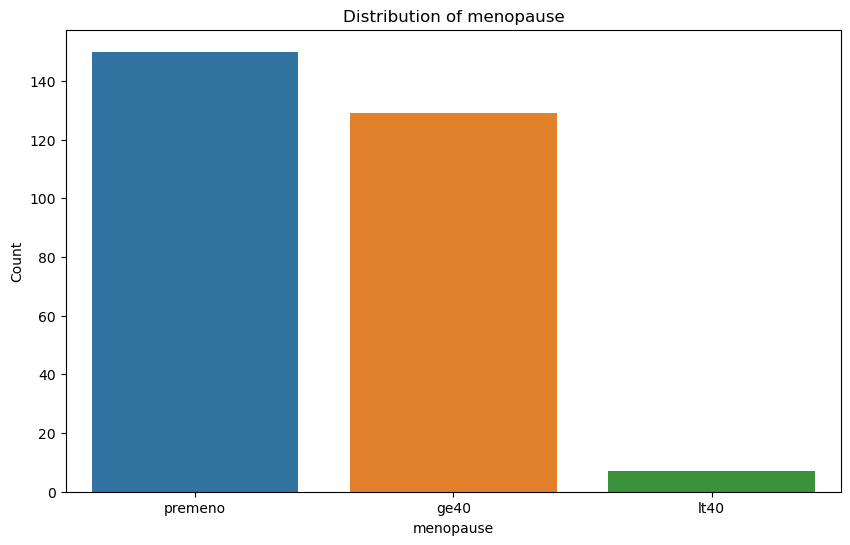

Feature: tumor-size
       count percentage
30-34     60      21.0%
25-29     54      18.9%
20-24     50      17.5%
15-19     30      10.5%
10-14     28       9.8%
40-44     22       7.7%
35-39     19       6.6%
0-4        8       2.8%
50-54      8       2.8%
5-9        4       1.4%
45-49      3       1.0% 




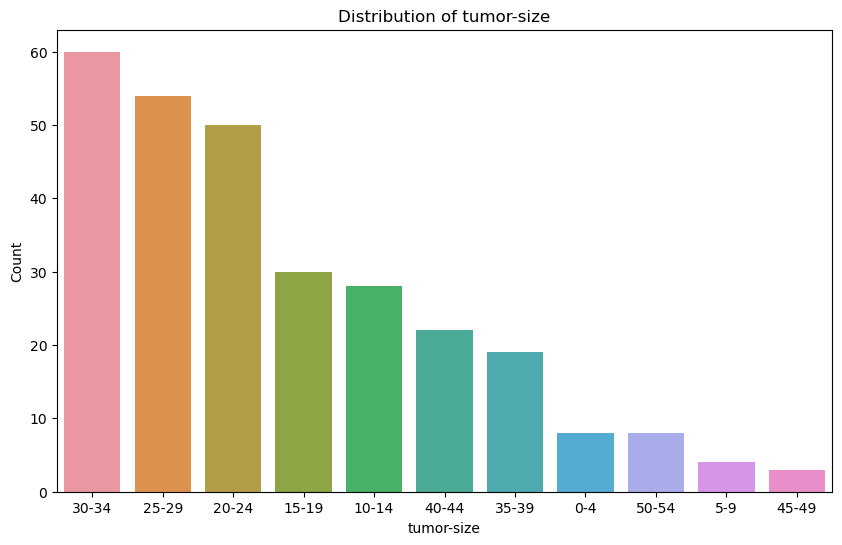

Feature: inv-nodes
       count percentage
0-2      213      74.5%
3-5       36      12.6%
6-8       17       5.9%
9-11      10       3.5%
15-17      6       2.1%
12-14      3       1.0%
24-26      1       0.3% 




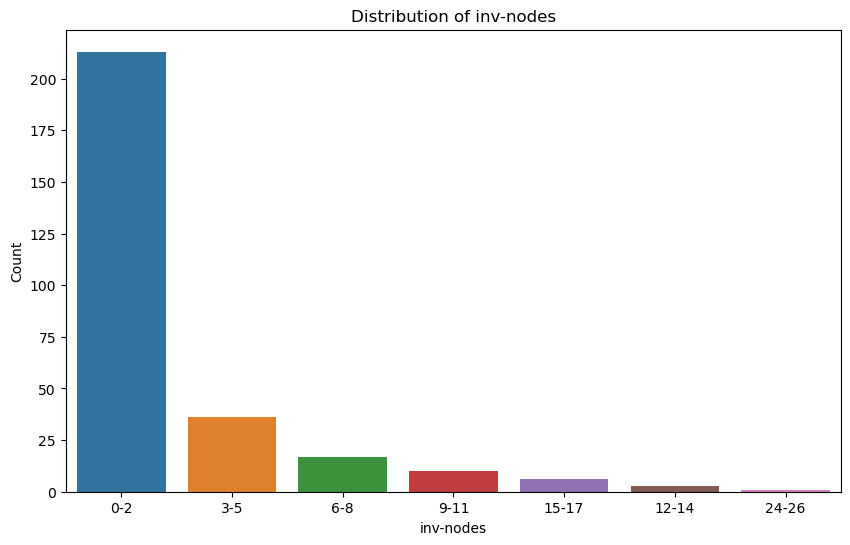

Feature: node-caps
     count percentage
no     222      77.6%
yes     56      19.6%
?        8       2.8% 




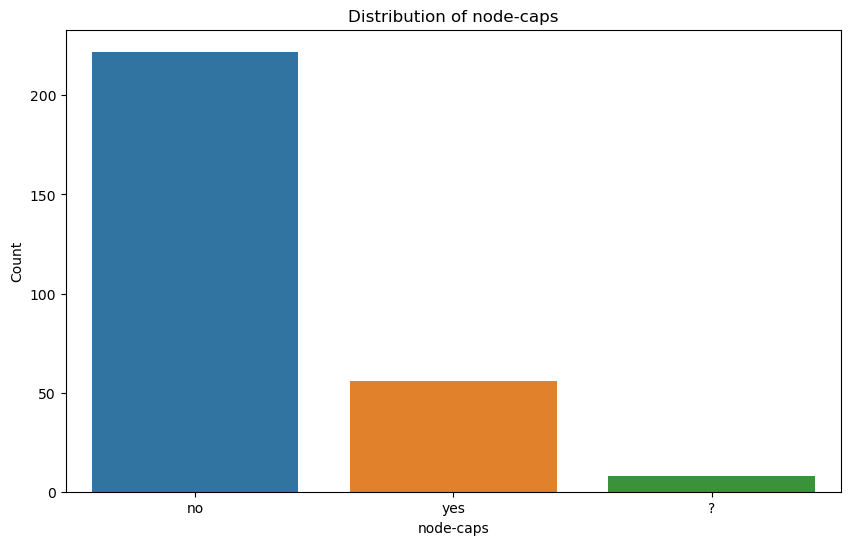

Feature: breast
       count percentage
left     152      53.1%
right    134      46.9% 




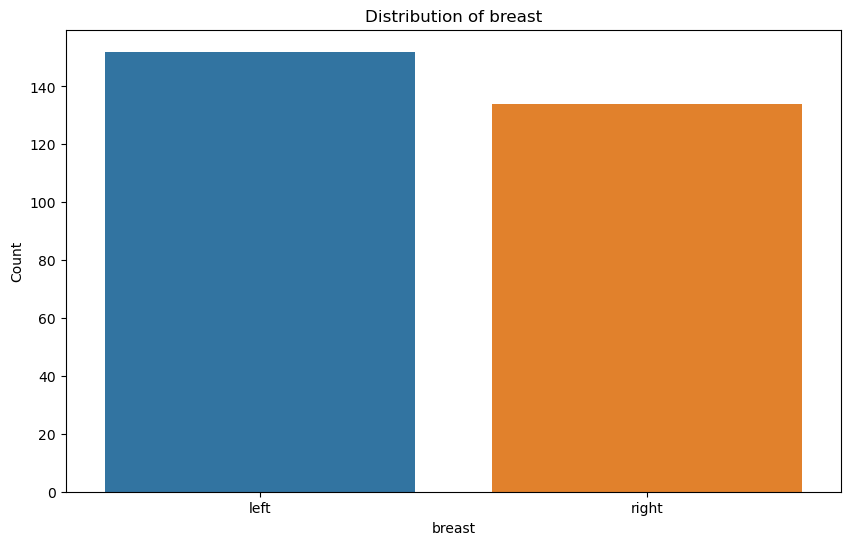

Feature: breast-quad
           count percentage
left_low     110      38.5%
left_up       97      33.9%
right_up      33      11.5%
right_low     24       8.4%
central       21       7.3%
?              1       0.3% 




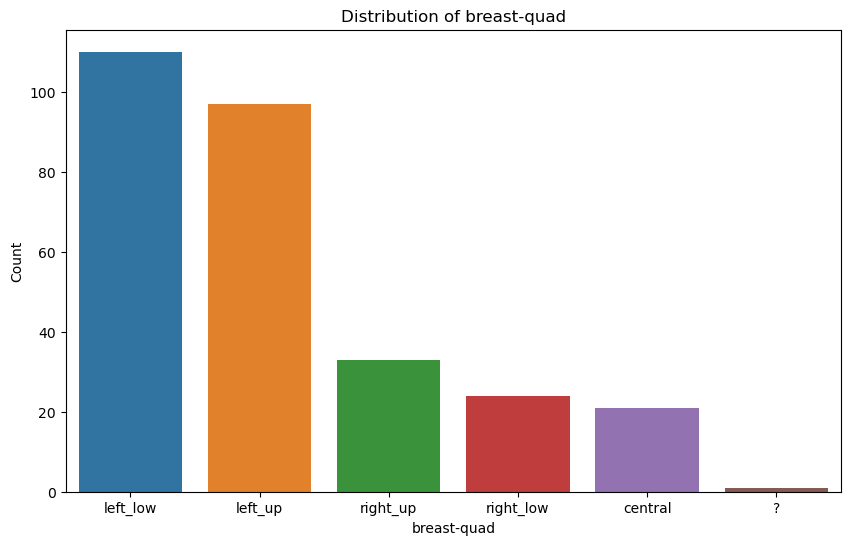

Feature: irradiat
     count percentage
no     218      76.2%
yes     68      23.8% 




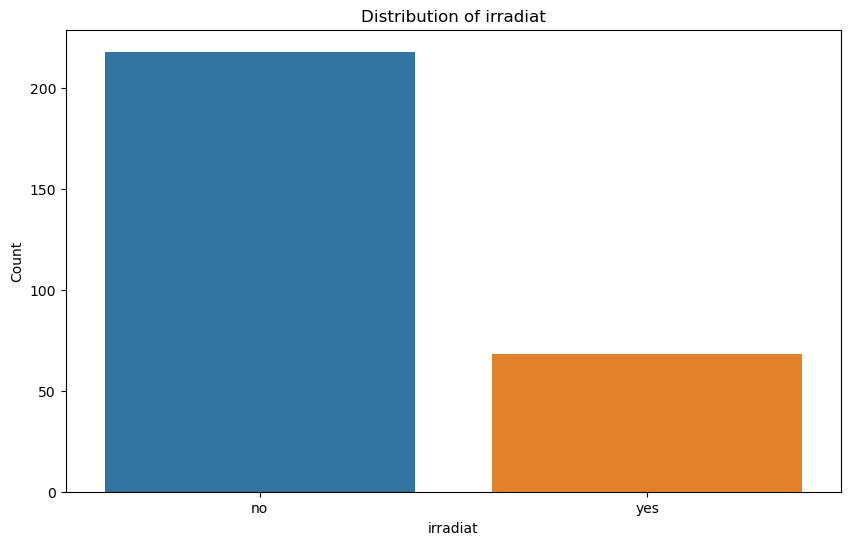

In [17]:
# # Calculate count and percentage of each unique value for each feature
for feature in categorical_features:
    counts = df[feature].value_counts()
    percentage = (df[feature].value_counts(normalize = True) * 100).round(1).astype(str) + '%'
    print('Feature: ' + feature)
    print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n\n')
    
    # Visualize Dristribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature, order=counts.index)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

**Observations:**
- As we saw earlier, the dataset has a relatively small sample size, which can limit the model's ability to generalize well to unseen data. Taking this into account, we will try to improve the models' performance by reducing the number of unique categories for each feature (grouping down to either 2 or 3 categories), ensuring that each category has a sufficient numer of instances. Based on the distributions shown above, here is how we will reorganize the groupings.

**Age**
- Group into two groups: 'Below 50' and '50 and Above'

**Menopause**
- Combine lt40 and ge40 into single category (postmeno)
- Keep premeno as a separate category

**Tumor Size**
- Group into three categories: 'Small' (0-14), 'Medium' (15-29) and 'Large' (30 and above)

**Node involvement**
- Group into three categories based on invovlement: 'Low' (0-2), 'Medium' (3-8) and 'High' (9 and above)

**Node-caps**
- Since we already have low number of samples, want to redistribute '?' instead of entirely remove
- Will redistribute according to ratio of 'yes' and 'no'

**Breast**
- This feature is already binary so no need to transform

**Breast Quad**
- Since there is only one '?', we will assign it to the most frequent category
- Will group the remainder into three categories: 'Left' (combining 'left_low' and 'left_up'), 'Right' (combining 'right_low' and 'right_up' and 'central'

**Irradiat**
- This feature is already binary so no need to transform

**Note:**
- In addition to these groupings, we will apply one-hot encoder to categorical features excluding 'Breast' and 'Irradiat'. Although many of these categorical features have ordinal ranking, we choose one-hot encoding over label encoding because one-hot encoding provides better interpretability for feature importance by showing the contributions of each category within each feature.
- Additionally, we will not apply StandardScaler on one-hot encoded features

2b. Transform Categorical features:

Next, we will transform the categorical features as described above and apply one-hot encoding. After that, we will visualize the newly transformed features.

_1. Age_

Feature: age_group
              count percentage
50 and above    159      55.6%
Below 50        127      44.4% 



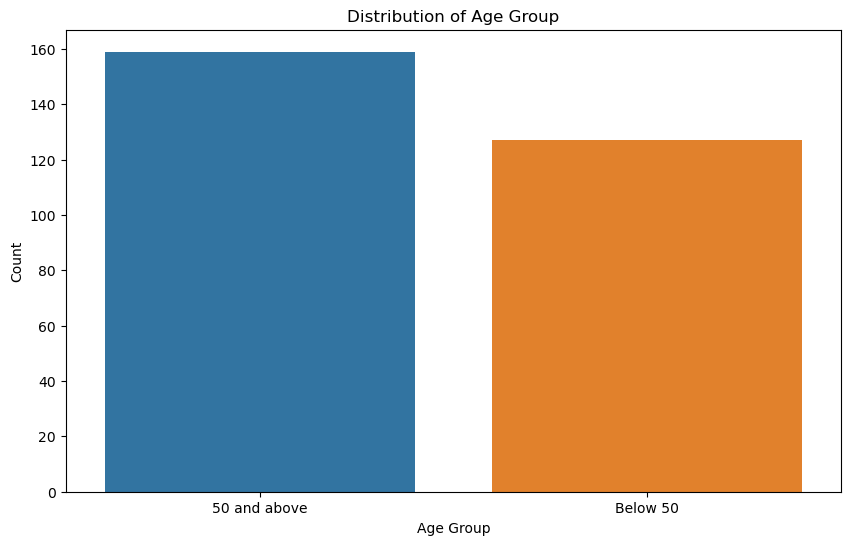

In [18]:
# Define age mapping 
age_mapping = {
    '20-29': 'Below 50',
    '30-39': 'Below 50',
    '40-49': 'Below 50',
    '50-59': '50 and above',
    '60-69': '50 and above',
    '70-79': '50 and above'
}

# Apply mapping
df['age_group'] = df['age'].replace(age_mapping)


# One-hot encode feature
encoder = OneHotEncoder(sparse = False)
age_group_encoded = encoder.fit_transform(df[['age_group']])
age_group_encoded_df = pd.DataFrame(age_group_encoded, columns = encoder.get_feature_names_out(['age_group']))

# Concatenate the original dataframe with the one-hot encoded columns
df = pd.concat([df, age_group_encoded_df], axis = 1)

# Perform univariate analysis on transformed feature
counts = df['age_group'].value_counts()
percentage = (df['age_group'].value_counts(normalize = True) * 100).round(1).astype(str) + '%'

# Print transformation results
print('Feature: age_group')
print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n')

# Visualize distribution post mapping
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'age_group', order = counts.index)
plt.title('Distribution of Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

_2. Menopausal Stage_

Feature: menopause_group
          count percentage
premeno     150      52.4%
postmeno    136      47.6% 



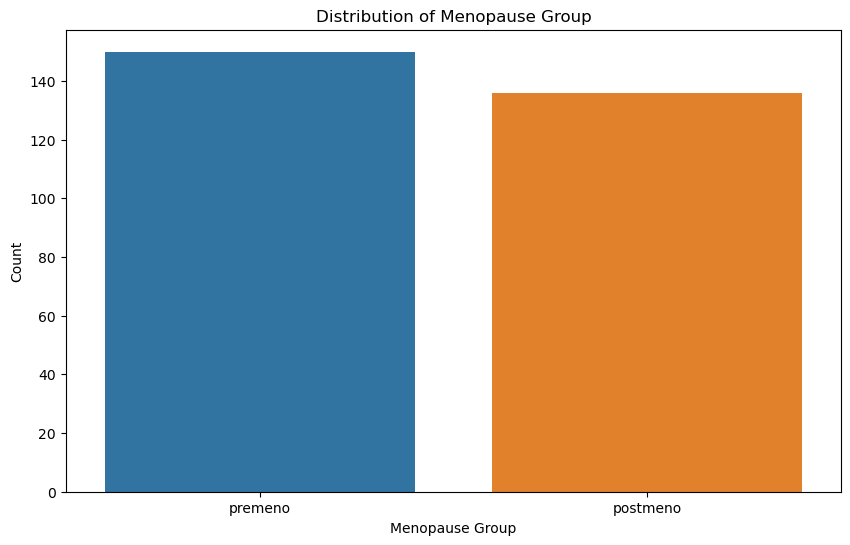

In [19]:
# Define menopause mapping 
menopause_mapping = {
    'premeno': 'premeno',
    'ge40': 'postmeno',
    'lt40': 'postmeno'
}

# Apply mapping
df['menopause_group'] = df['menopause'].replace(menopause_mapping)

# One-hot encode feature
encoder = OneHotEncoder(sparse = False)
menopause_group_encoded = encoder.fit_transform(df[['menopause_group']])
menopause_group_encoded_df = pd.DataFrame(menopause_group_encoded, columns = encoder.get_feature_names_out(['menopause_group']))

# Concatenate the original dataframe with the one-hot encoded columns
df = pd.concat([df, menopause_group_encoded_df], axis = 1)


# Perform univariate analysis on transformed feature
counts = df['menopause_group'].value_counts()
percentage = (df['menopause_group'].value_counts(normalize = True) * 100).round(1).astype(str) + '%'

# Print transformation results
print('Feature: menopause_group')
print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n')

# Visualize distribution post mapping
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'menopause_group', order=counts.index)
plt.title('Distribution of Menopause Group')
plt.xlabel('Menopause Group')
plt.ylabel('Count')
plt.show()

_3. Tumor Size_

Feature: tumor_size_group
        count percentage
Medium    134      46.9%
Large     112      39.2%
Small      40      14.0% 



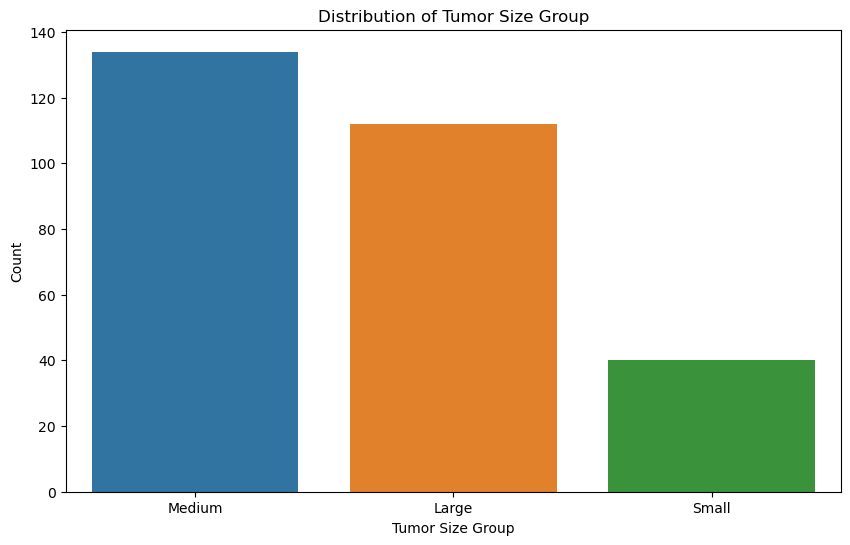

In [20]:
# Define tumor-size mapping
tumor_size_mapping = {
    '0-4': 'Small',
    '5-9': 'Small',
    '10-14': 'Small',
    '15-19': 'Medium',
    '20-24': 'Medium',
    '25-29': 'Medium',
    '30-34': 'Large',
    '35-39': 'Large',
    '40-44': 'Large',
    '45-49': 'Large',
    '50-54': 'Large'
}

# Apply the mapping
df['tumor_size_group'] = df['tumor-size'].replace(tumor_size_mapping)

# One-hot encode feature
encoder = OneHotEncoder(sparse = False)
tumor_size_group_encoded = encoder.fit_transform(df[['tumor_size_group']])
tumor_size_group_encoded_df = pd.DataFrame(tumor_size_group_encoded, columns = encoder.get_feature_names_out(['tumor_size_group']))

# Concatenate the original dataframe with the one-hot encoded columns
df = pd.concat([df, tumor_size_group_encoded_df], axis = 1)


# Perform univariate analysis on transformed feature
counts = df['tumor_size_group'].value_counts()
percentage = (df['tumor_size_group'].value_counts(normalize = True) * 100).round(1).astype(str) + '%'

# Print transformation results
print('Feature: tumor_size_group')
print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n')

# Visualize distribution post mapping
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'tumor_size_group', order = counts.index)
plt.title('Distribution of Tumor Size Group')
plt.xlabel('Tumor Size Group')
plt.ylabel('Count')
plt.show()

_4. Number of nodes involved (inv_nodes)_

Feature: inv_nodes_group
        count percentage
Low       213      74.5%
Medium     53      18.5%
High       20       7.0% 



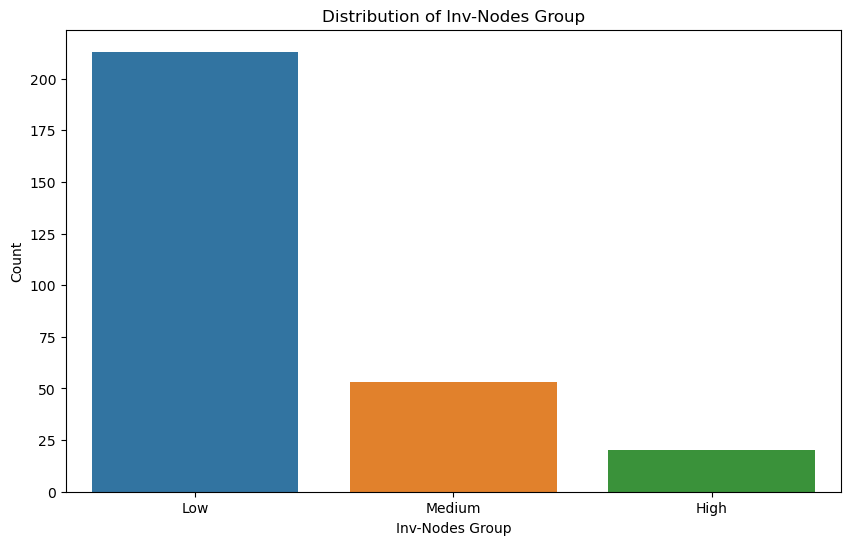

In [21]:
# Define inv_nodes mapping
inv_nodes_mapping = {
    '0-2': 'Low',
    '3-5': 'Medium',
    '6-8': 'Medium',
    '9-11': 'High',
    '12-14': 'High',
    '15-17': 'High',
    '24-26': 'High'
}

# Apply mapping
df['inv_nodes_group'] = df['inv-nodes'].replace(inv_nodes_mapping)

# One-hot encode feature
encoder = OneHotEncoder(sparse = False)
inv_nodes_group_encoded = encoder.fit_transform(df[['inv_nodes_group']])
inv_nodes_group_encoded_df = pd.DataFrame(inv_nodes_group_encoded, columns = encoder.get_feature_names_out(['inv_nodes_group']))

# Concatenate the original dataframe with the one-hot encoded columns
df = pd.concat([df, inv_nodes_group_encoded_df], axis = 1)

# Perform univariate analysis on transformed feature
counts = df['inv_nodes_group'].value_counts()
percentage = (df['inv_nodes_group'].value_counts(normalize = True) * 100).round(1).astype(str) + '%'

# Print transformation results
print('Feature: inv_nodes_group')
print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n')

# Visualize distribution post mapping
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'inv_nodes_group', order = counts.index)
plt.title('Distribution of Inv-Nodes Group')
plt.xlabel('Inv-Nodes Group')
plt.ylabel('Count')
plt.show()

**Note:**
- While the distribution among the different categories is somewhat uneven, this categorization more closely reflects real-life groupings.

_5. Presence of extracapsular extension (node-caps)_

Feature: node-caps
     count percentage
no     229      80.1%
yes     57      19.9% 



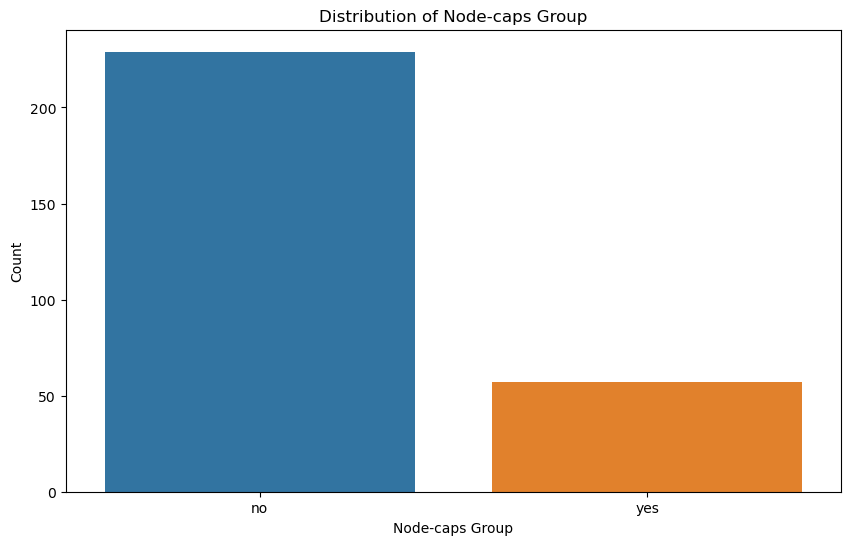

In [22]:
# Going to redistribute '?' according to ratio of 'yes' and 'no'

# Calculate the ratios of 'yes' and 'no'
count_no = df['node-caps'].value_counts()['no']
count_yes = df['node-caps'].value_counts()['yes']
total_known = count_no + count_yes

ratio_no = count_no / total_known
ratio_yes = count_yes / total_known

# Number of '?' values to be redistributed
num_unknown = df['node-caps'].value_counts()['?']

# Calculate the number of '?' to assign to 'yes' and 'no'
num_yes_assign = int(round(ratio_yes * num_unknown))
num_no_assign = num_unknown - num_yes_assign

# Randomly assign 'yes' and 'no' to the '?' values

# generate array of replacement values for all '?', replace based on parameter p which represents ratio of 'yes' and 'no'
replacement_values = np.random.choice(['yes', 'no'], size = num_unknown, p = [ratio_yes, ratio_no])

# fill missing data with replacement values
df.loc[df['node-caps'] == '?', 'node-caps'] = replacement_values

# One-hot encode feature
encoder = OneHotEncoder(sparse = False)
node_caps_encoded = encoder.fit_transform(df[['node-caps']])
node_caps_encoded_df = pd.DataFrame(node_caps_encoded, columns = encoder.get_feature_names_out(['node-caps']))

# Concatenate the original dataframe with the one-hot encoded columns
df = pd.concat([df, node_caps_encoded_df], axis = 1)

# Perform univariate analysis on transformed feature
counts = df['node-caps'].value_counts()
percentage = (df['node-caps'].value_counts(normalize = True) * 100).round(1).astype(str) + '%'

# Print transformation results
print('Feature: node-caps')
print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n')

# Visualization
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'node-caps', order = counts.index)
plt.title('Distribution of Node-caps Group')
plt.xlabel('Node-caps Group')
plt.ylabel('Count')
plt.show()

_6. Breast Quadrant_

Feature: breast_quad_group
         count percentage
Left       208      72.7%
Right       57      19.9%
Central     21       7.3% 



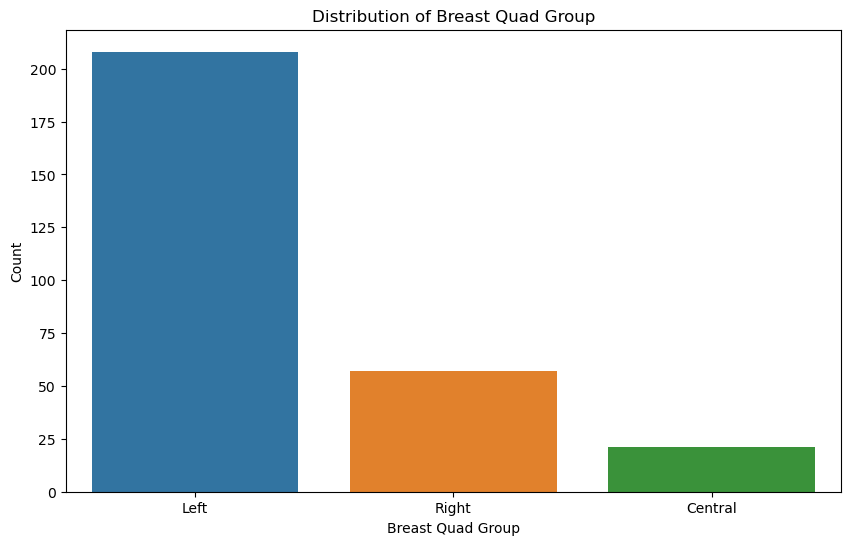

In [23]:
# Remove the '?' value by assigning it to the most frequent category which is left_low as we saw above
df['breast-quad'].replace('?', 'left_low', inplace=True)

# Define breast_quad mapping
breast_quad_mapping = {
    'left_low': 'Left',
    'left_up': 'Left',
    'right_up': 'Right',
    'right_low': 'Right',
    'central': 'Central'
}

# Apply mapping
df['breast_quad_group'] = df['breast-quad'].replace(breast_quad_mapping)


# One-hot encode feature
encoder = OneHotEncoder(sparse = False)
breast_quad_group_encoded = encoder.fit_transform(df[['breast_quad_group']])
breast_quad_group_encoded_df = pd.DataFrame(breast_quad_group_encoded, columns = encoder.get_feature_names_out(['breast_quad_group']))

# Concatenate the original dataframe with the one-hot encoded columns
df = pd.concat([df, breast_quad_group_encoded_df], axis = 1)


# Perform univariate analysis on transformed feature
counts = df['breast_quad_group'].value_counts()
percentage = (df['breast_quad_group'].value_counts(normalize = True) * 100).round(1).astype(str) + '%'

# Print transformation results
print('Feature: breast_quad_group')
print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n')

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data = df, x = 'breast_quad_group', order = counts.index)
plt.title('Distribution of Breast Quad Group')
plt.xlabel('Breast Quad Group')
plt.ylabel('Count')
plt.show()

_7. Breast Location and Irradiat_

In [24]:
# 7. Label encode the remaining two categorical variables: Breast and Irradiat

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Label encode the 'breast' feature
df['breast_encoded'] = label_encoder.fit_transform(df['breast'])

# Label encode the 'irradiat' feature
df['irradiat_encoded'] = label_encoder.fit_transform(df['irradiat'])

2c. Univariate analysis for original numeric features:

Feature: deg-malig
   count percentage
2    130      45.5%
3     85      29.7%
1     71      24.8% 




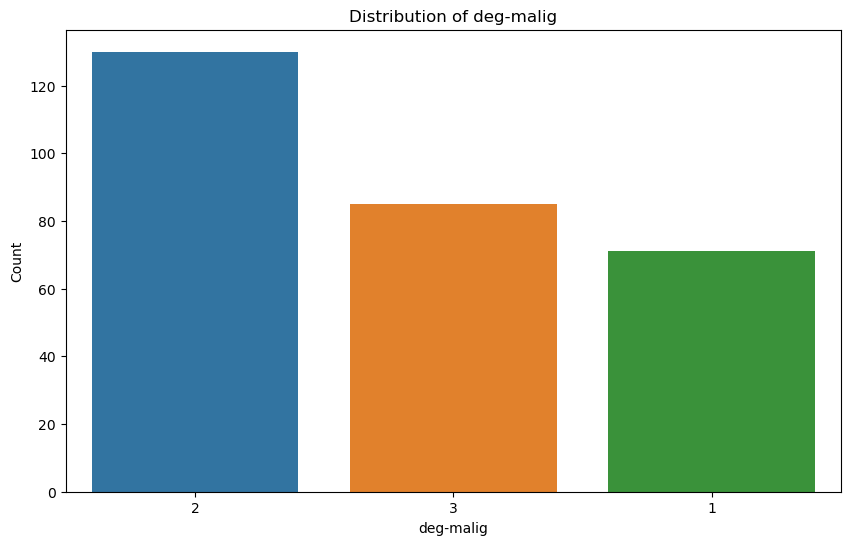

In [25]:
# Display value counts for each class per feature
for feature in numeric_features:
    counts = df[feature].value_counts()
    percentage = (df[feature].value_counts(normalize = True) * 100).round(1).astype(str) + '%'
    print('Feature: ' + feature)
    print(pd.DataFrame({'count': counts, 'percentage': percentage}), '\n\n')
    
    # Visualize Dristribution
    plt.figure(figsize = (10, 6))
    sns.countplot(data = df, x = feature, order = counts.index)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

In [26]:
# Overview of dataframe with newly encoded features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Class                      286 non-null    int64  
 1   age                        286 non-null    object 
 2   menopause                  286 non-null    object 
 3   tumor-size                 286 non-null    object 
 4   inv-nodes                  286 non-null    object 
 5   node-caps                  286 non-null    object 
 6   deg-malig                  286 non-null    int64  
 7   breast                     286 non-null    object 
 8   breast-quad                286 non-null    object 
 9   irradiat                   286 non-null    object 
 10  age_group                  286 non-null    object 
 11  age_group_50 and above     286 non-null    float64
 12  age_group_Below 50         286 non-null    float64
 13  menopause_group            286 non-null    object 

**3. Bivariate Analysis**

In this section, we will examine the relationship between each feature with respect to target variable.

In [27]:
# Create a function to generate cout plot to visualize distribution of a feature against target variable
def bivariate_plot(df, feature, target='Class'):
    plt.figure(figsize = (10, 6))
    plot = sns.countplot(x = feature, hue = target, data = df)
    plt.title(f'Distribution of Recurrence vs No Recurrence by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title = 'Class', labels = ["Non-Recurrence", 'Recurrence'])

    # Display count labels
    for container in plot.containers:
        plot.bar_label(container, label_type='edge')

    plt.show()

In [28]:
# List of columns to use for bivariate analysis
feature_groups = [
    'deg-malig',
    'age_group', 'menopause_group',
    'tumor_size_group', 'inv_nodes_group', 
    'node-caps', 'breast_quad_group','breast_encoded', 'irradiat_encoded'
]

# Create a new DataFrame with the selected columns for visualization
df_visualization = df[feature_groups]

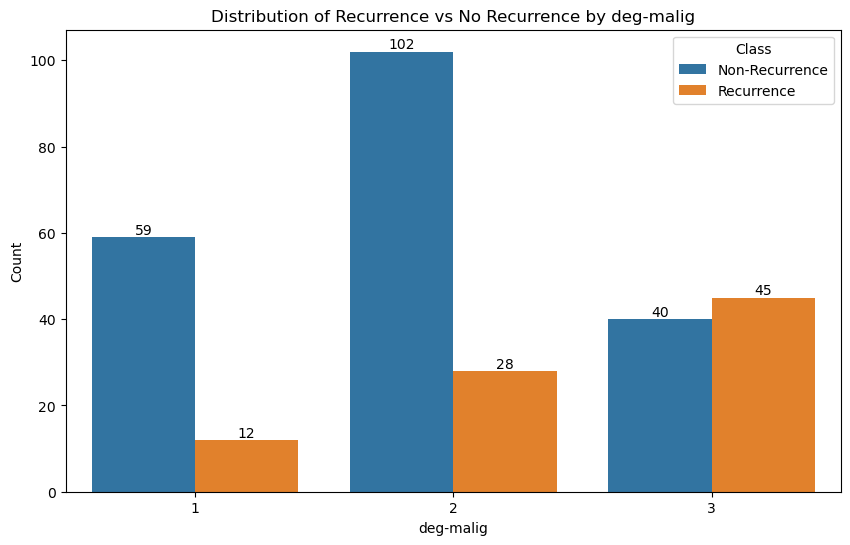

In [29]:
bivariate_plot(df, feature_groups[0])

**Observations:**
- For degree malignancy of 1, the vast majority of cases are non-recurrence (59/71 = 83%). 
- For degree malignancy of 2, the vast majority of cases are still non-recurrence (102/130 = 78%). However, there is a notable increase in proportion of recurrence compared to degree malignancy of 1.
- For degree malignancy of 3, the proportion of recurrence case increases significantly to 53% (45/85).
- Based on these proportions, this suggests that **higher degree of malignancy is strongly associated with recurrence.**

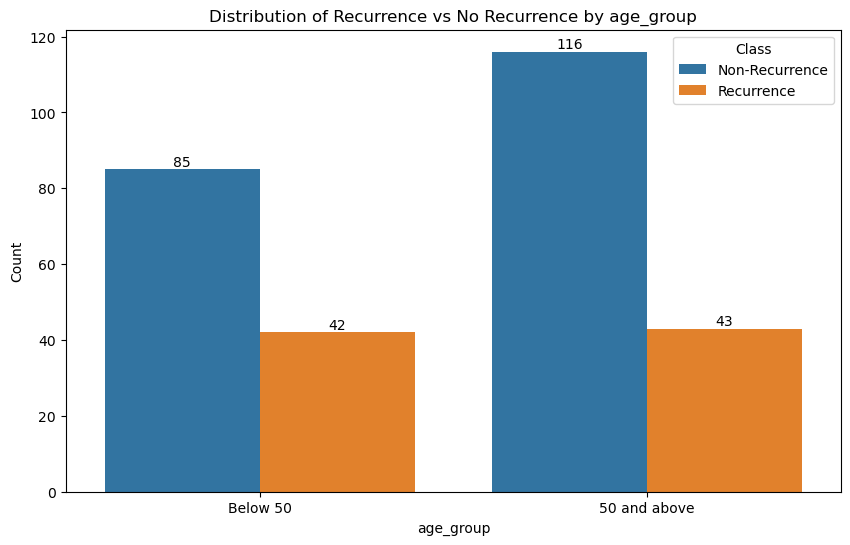

In [30]:
bivariate_plot(df, feature_groups[1])

**Observations:**
- For age group 'Below 50', the proportion of non-recurrence and recurrence are 67% (85/127) and 33% (42/127) respectively.
- For age group '50 and above', the proportion of non-recurrence and recurrence are 73% (116/159) and 27% (43/159) respectively.
- Age appears to be a significant factor in recurrence rate, with younger patients experiencing higher recurrence rate.

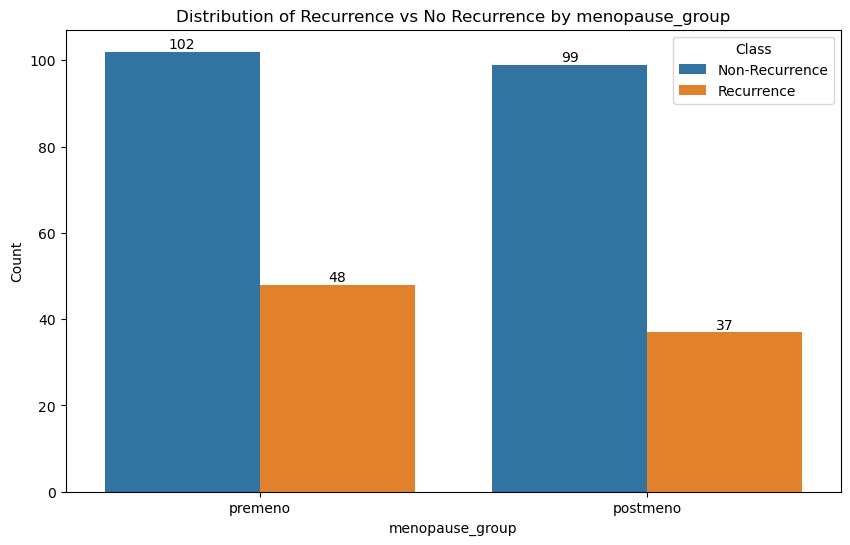

In [31]:
bivariate_plot(df, feature_groups[2])

**Observations:**
- The proportion of recurrence cases in the premenopausal group and postmenopausal group are 32% (48/150) and 27 (37/136) respectively.
- This suggests that menopausal status is an important factor to consider, with premenopausal patients having higher rate of recurrence.

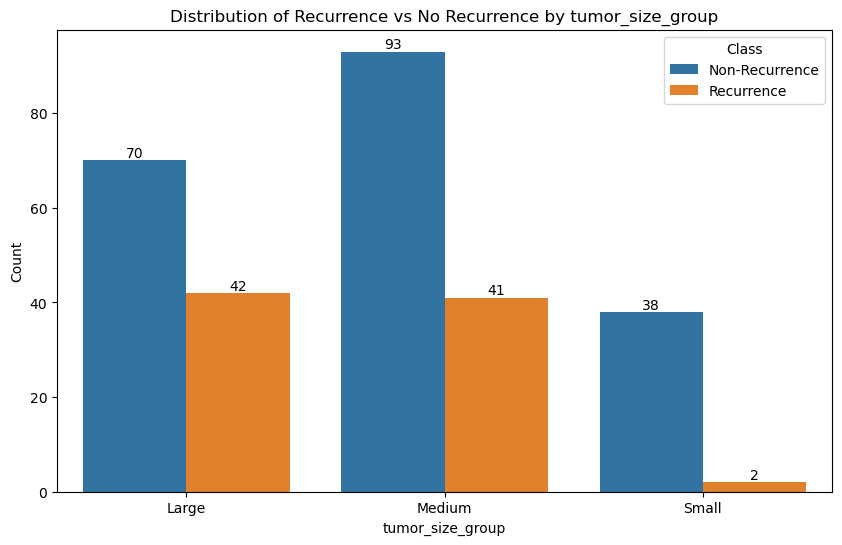

In [32]:
bivariate_plot(df, feature_groups[3])

**Observations:**
- The proportion of recurrence cases from Large to Small are 38% (42/112), 31% (41/134) and 5% (2/40).
- Overall, this suggests that larger tumor size is associated with higher rate of recurrence.

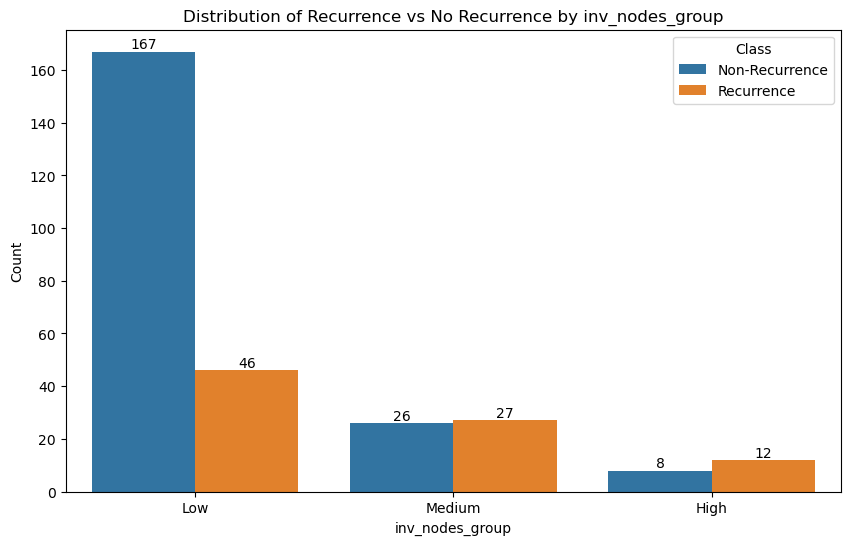

In [33]:
bivariate_plot(df, feature_groups[4])

**Observations:**
- For 'Low' inv_nodes_group, the proportion of recurrence cases is 22% (46/213)
- For 'Medium' inv_nodes_group, the proportion of recurrence cases is 51% (27/53)
- For 'High' inv_nodes_group, the proportion of recurrence cases is 60% (12/20)
- Overall, higher number of invasive nodes is associated with higher rate of recurrence.

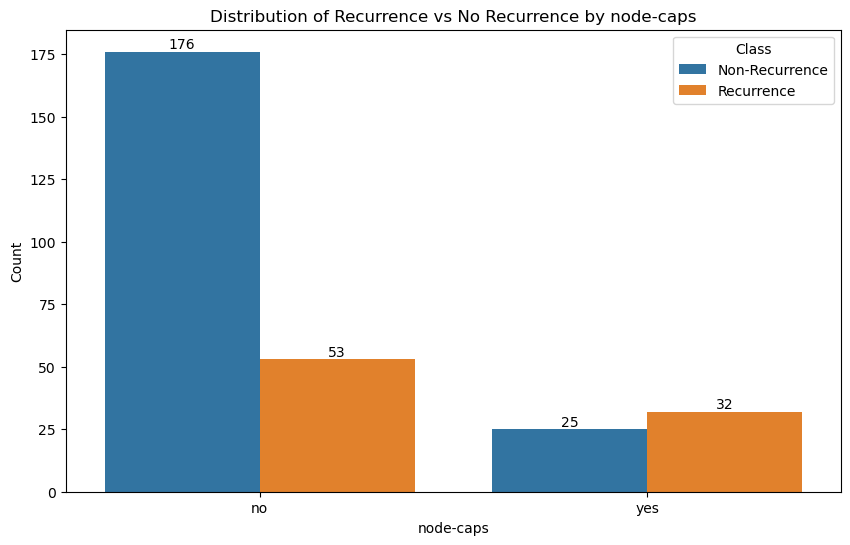

In [34]:
bivariate_plot(df, feature_groups[5])

**Observations:**
- Patients without node caps have lower likelihood of recurrence (52/226 or 23%) compared to patients with node caps (33/60 or 55%).

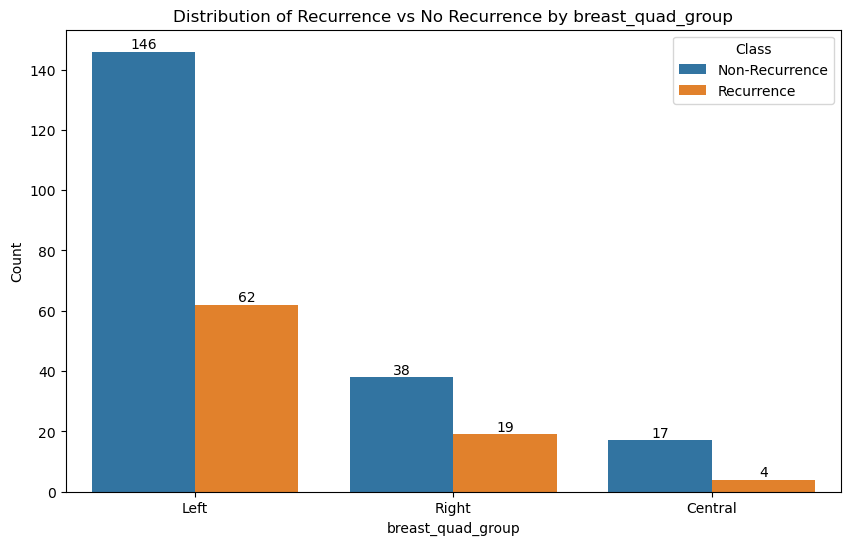

In [35]:
bivariate_plot(df, feature_groups[6])

**Observations:**
- Patients with tumors in left breast quadrant have recurrence rate of 62/208 (30%)
- Patients with tumors in right breast quadrant have recurrence rate of 19/57 (33%)
- Patient with tumors in central quadrant have recurrence rate of 4/21 (19%)

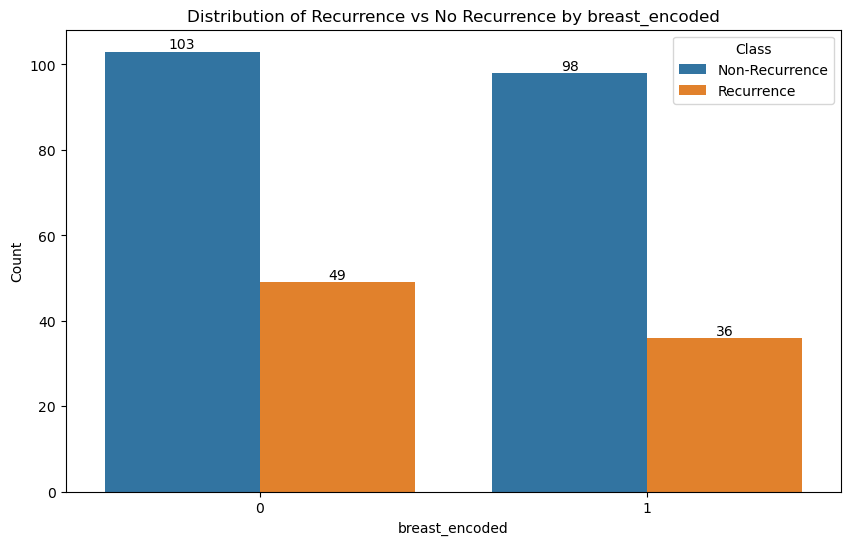

In [36]:
bivariate_plot(df, feature_groups[7])

**Note:**
- 0 represents Left
- 1 represents Right

**Observations:**
- Patients with tumors on left side have recurrence rate of 32% (49/152) while patients with tumors on right side have recurrence rate of 27% (36/134)
- Appears to suggest that left side is associated with higher rate of recurrence.

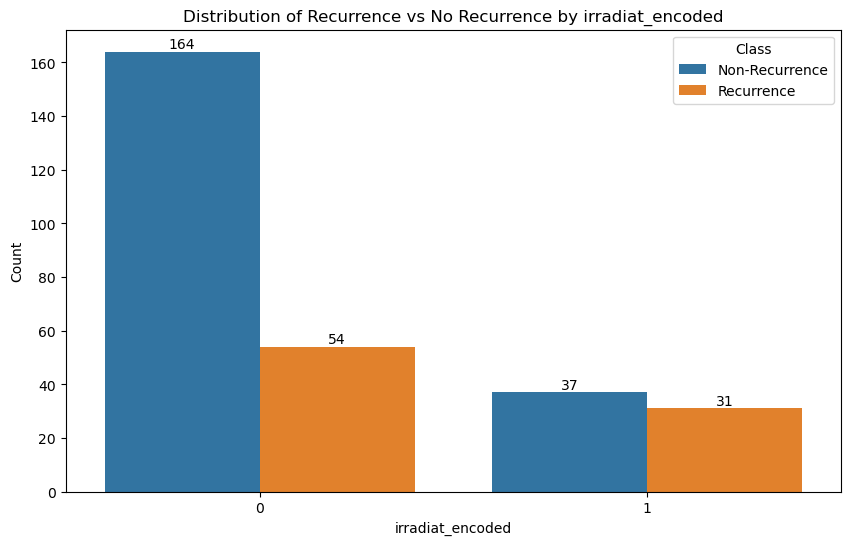

In [37]:
bivariate_plot(df, feature_groups[8])

**Observations:**
- Patients who did not undergo irradiation have recurrence rate of 25% (54/218)
- Patients who did undergo irradiation have recurrence rate of 46% (31/68)
- This seems a bit counterintuitive since irradiation is typically used to treat cancer.
- To better understand this feature, additional information is needed.

## Exploration of Different Models

In this section, we will train four models with default parameters:
1. Logistic Regression
2. Decision Tree
3. K Neighbors
4. Support Vector Machine

We will evaluate the models performance on both the train and test dataset. Afterwards, we will try to improve each model's performance by hyperparameter tuning using GridSearchCV.

In [38]:
# Generate final dataframe with encoded features

# List of columns to keep
columns_to_keep = [
    'Class', 'deg-malig',
    'age_group_50 and above', 'age_group_Below 50',
    'menopause_group_postmeno', 'menopause_group_premeno',
    'tumor_size_group_Large', 'tumor_size_group_Medium',
    'tumor_size_group_Small', 'inv_nodes_group_High', 'inv_nodes_group_Medium',
    'node-caps_no', 'node-caps_yes', 'breast_quad_group_Central', 'breast_quad_group_Left',
    'breast_quad_group_Right', 'breast_encoded', 'irradiat_encoded'
]

# Create a new DataFrame with the selected columns
df_final = df[columns_to_keep]

In [39]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Class                      286 non-null    int64  
 1   deg-malig                  286 non-null    int64  
 2   age_group_50 and above     286 non-null    float64
 3   age_group_Below 50         286 non-null    float64
 4   menopause_group_postmeno   286 non-null    float64
 5   menopause_group_premeno    286 non-null    float64
 6   tumor_size_group_Large     286 non-null    float64
 7   tumor_size_group_Medium    286 non-null    float64
 8   tumor_size_group_Small     286 non-null    float64
 9   inv_nodes_group_High       286 non-null    float64
 10  inv_nodes_group_Medium     286 non-null    float64
 11  node-caps_no               286 non-null    float64
 12  node-caps_yes              286 non-null    float64
 13  breast_quad_group_Central  286 non-null    float64

In [40]:
# Assign depedent and indepent variables to appropriate variables
y = df_final['Class']
X = df_final.drop(columns='Class', axis = 1)

In [41]:
X

,deg-malig,age_group_50 and above,age_group_Below 50,menopause_group_postmeno,menopause_group_premeno,tumor_size_group_Large,tumor_size_group_Medium,tumor_size_group_Small,inv_nodes_group_High,inv_nodes_group_Medium,node-caps_no,node-caps_yes,breast_quad_group_Central,breast_quad_group_Left,breast_quad_group_Right,breast_encoded,irradiat_encoded
0,3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
1,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
2,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
3,2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0
4,2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
282,3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
283,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0
284,3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0


In [42]:
# Include stratify parameter to ensure proportion of classes in target variable is equivalent in both the training and test set
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.30, random_state = 42, stratify = y)

In [43]:
# We will store values into appropriate list which will later be used this lists to create a dataframe to display results
model_list = []

train_accuracy_list = []
test_accuracy_list = []

train_precision_list = []
test_precision_list = []

train_recall_list = []
test_recall_list = []

train_f1_list = []
test_f1_list = []

In [44]:
# Base line models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'Support Vector machine': SVC()
}

for i in range(len(list(models))):
    
    model = list(models.values())[i]
    
    # append current model to list
    model_list.append(model)
    
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average = 'weighted')
    
    # Testing set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average = 'weighted')
    
    # Append results to list
    train_accuracy_list.append(model_train_accuracy)
    test_accuracy_list.append(model_test_accuracy)

    train_precision_list.append(model_train_precision)
    test_precision_list.append(model_test_precision)

    train_recall_list.append(model_train_recall)
    test_recall_list.append(model_test_recall)
    
    train_f1_list.append(model_train_f1)
    test_f1_list.append(model_test_f1)

In [45]:
# Display base model results in DataFrame
base_model_results_df = pd.DataFrame({'Model': model_list, 'Train Accuracy' : train_accuracy_list, 'Test Accuracy' : test_accuracy_list, 'Train Precision' : train_precision_list, 'Test Precision' : test_precision_list, 'Train Recall' : train_recall_list, 'Test Recall' : test_recall_list, 'Train f1' : train_f1_list, 'Test f1' : test_f1_list})
base_model_results_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train f1,Test f1
0,LogisticRegression(),0.750,0.720930,0.636364,0.571429,0.355932,0.307692,0.725226,0.691755
1,DecisionTreeClassifier(),0.935,0.732558,0.979167,0.571429,0.796610,0.461538,0.932879,0.723681
2,KNeighborsClassifier(),0.785,0.674419,0.750000,0.428571,0.406780,0.230769,0.762498,0.640381
3,SVC(),0.800,0.744186,0.952381,0.700000,0.338983,0.269231,0.764375,0.702386


**Initial Evaluation:**
- Given the presence of class imbalance in the target variable, accuracy is not a reliable metric to use. Instead, we will focus on other metrics such as precision, recall, F1. Among the three metrics, recall is a priority because the aim is to identify as many true positive cases. 
- Logistic Regression model exhibits moderate precision (0.571429) and low recall (0.307692). Having a low recall means that the model fails to identify a significant portion of true positive. 
- Decision Tree model shows a notable drop in precision and recall in the test set which indicates overfitting. That being said, the recall (0.461538) is slightly better than recall in Logistic Regression model
- KNeighbors model shows similar performance as Logistic Regression model: moderate precision and low recall.
- Support Vector Machine has the lowest recall among the models (0.269231)

## Hyperparameter tuning and Model Evaluation

In [46]:
# Defining parameter grids
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000, 20000]
}

dt_params = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

knn_params = {
    'n_neighbors': range(1, 30, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

In [47]:
# Model list for hyperparameter tuning
gridsearchcv_models = [
    ("Logistic Regression", LogisticRegression(), lr_params),
    ("Decision Tree", DecisionTreeClassifier(), dt_params),
    ("KNeighbors",  KNeighborsClassifier(), knn_params),
    ("Support Vector Machine", SVC(), svm_params)
]

In [48]:
# add improved model labels to list
model_list.append('Logistic Regression GridSearchCV')
model_list.append('Decision Tree GridSearchCV')
model_list.append('KNeighbors GridSearchCV')
model_list.append('Support Vector Machine GridSearchCV')

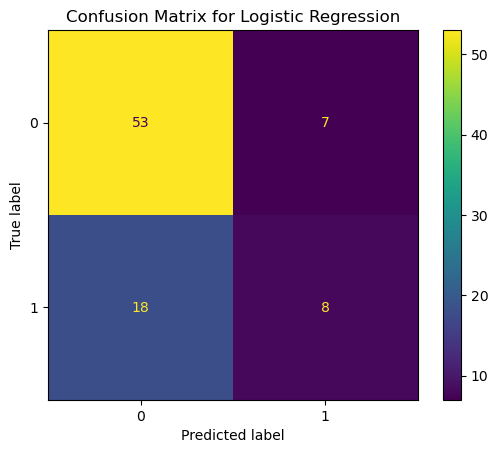

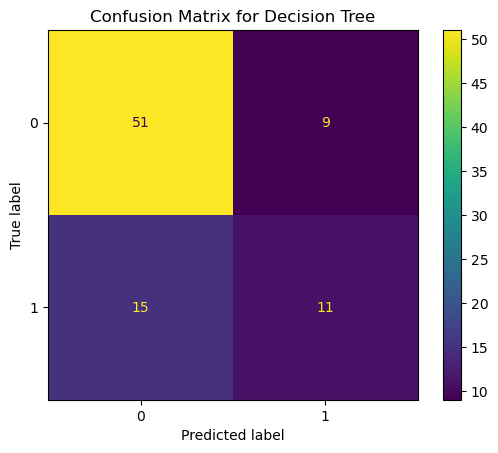

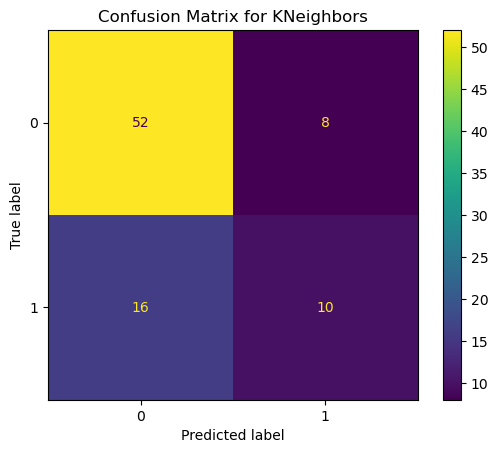

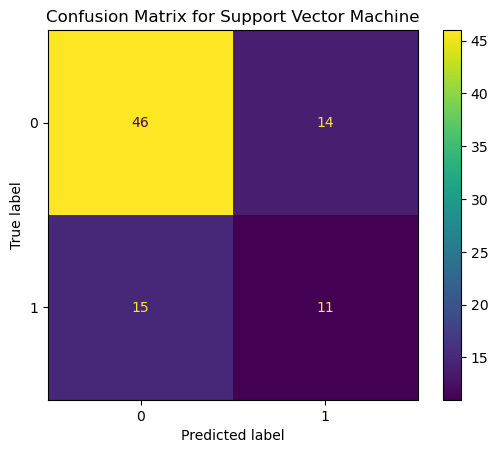

In [49]:
# Dictionary to store the best parameters, feature importances, and scores
import warnings
warnings.filterwarnings("ignore")

model_param = {}
feature_importances = {}
model_scores = {}
best_cv_scores = {}

# We will try to improve the base models through hyperparameter tuning
for name, model, params in gridsearchcv_models:
    # We set scoring to recall since recall is our priority
    # We reduce the cross validation value from 5 to 3 due to small dataset size
    grid = GridSearchCV(estimator = model, param_grid = params, cv = 3, n_jobs = -1, scoring = 'recall')
    
    try:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        
        model_param[name] = grid.best_params_
        best_cv_scores[name] = grid.best_score_

        # Some models provide feature importance
        # We can use hasattr function to check if a model has a specific attribute; in this case,
        # feature importance or coefficients
        if hasattr(best_model, 'feature_importances_'):
            feature_importances[name] = best_model.feature_importances_
        elif hasattr(best_model, 'coef_'):
            feature_importances[name] = best_model.coef_[0]
        else:
            feature_importances[name] = None

        # Train set performance
        y_train_pred = best_model.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        precision_train = precision_score(y_train, y_train_pred)
        recall_train = recall_score(y_train, y_train_pred)
        f1_train = f1_score(y_train, y_train_pred, average='weighted')

        # Test set performance
        y_test_pred = best_model.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred)
        recall_test = recall_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        
        
        # Confusion matrix visualization to show breakdown of model's performance
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for {name}')
        plt.show()
        
         # Append results to list
        train_accuracy_list.append(accuracy_train)
        test_accuracy_list.append(accuracy_test)

        train_precision_list.append(precision_train)
        test_precision_list.append(precision_test)

        train_recall_list.append(recall_train)
        test_recall_list.append(recall_test)

        train_f1_list.append(f1_train)
        test_f1_list.append(f1_test)

    except Exception as e:
        print(f"Error for model {name}: {e}")

Confusion matrices are a great way to visualize the performance of a classification model. They provide breakdown into the following key components:
- _True Positives_: How many actual postive cases were correctly identified by the model
- _True Negatives_: How many actual negative cases were correctly identified by the model
- _False Positive_: How many times the model incorrectly identified negative instances as positive
- _False Negative_: How many times model incorrectly identified positive instances as negative


1. _Logistic Regression Confusion Matrix_
- True Positives: 8
- True Negatives: 54
- False Positive: 6
- False Negative: 18

2. _Decision Tree Confusion Matrix_
- True Positives: 12
- True Negatives: 48
- False Positive: 12
- False Negative: 14

3. _Kneighbors Confusion Matrix_
- True Positives: 10
- True Negatives: 50
- False Positive: 10
- False Negative: 16

4. _Support Vector Machine Confusion Matrix_
- True Positives: 10
- True Negatives: 46
- False Positive: 14
- False Negative: 16


As we can see, all four models have low true positive count, resulting in low recall. However recall is an essential metric in this context, as identifying patients at risk of recurrence is a priority.


**Updated table with all models:**

In [50]:
every_model_results_df = pd.DataFrame({'Model': model_list, 'Train Accuracy' : train_accuracy_list, 'Test Accuracy' : test_accuracy_list, 'Train Precision' : train_precision_list, 'Test Precision' : test_precision_list, 'Train Recall' : train_recall_list, 'Test Recall' : test_recall_list, 'Train f1' : train_f1_list, 'Test f1' : test_f1_list})
every_model_results_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train f1,Test f1
0,LogisticRegression(),0.750,0.720930,0.636364,0.571429,0.355932,0.307692,0.725226,0.691755
1,DecisionTreeClassifier(),0.935,0.732558,0.979167,0.571429,0.796610,0.461538,0.932879,0.723681
2,KNeighborsClassifier(),0.785,0.674419,0.750000,0.428571,0.406780,0.230769,0.762498,0.640381
3,SVC(),0.800,0.744186,0.952381,0.700000,0.338983,0.269231,0.764375,0.702386
4,Logistic Regression GridSearchCV,0.750,0.709302,0.636364,0.533333,0.355932,0.307692,0.725226,0.682511
5,Decision Tree GridSearchCV,0.935,0.720930,0.979167,0.550000,0.796610,0.423077,0.932879,0.709375
6,KNeighbors GridSearchCV,0.910,0.720930,0.815385,0.555556,0.898305,0.384615,0.911199,0.704281
7,Support Vector Machine GridSearchCV,0.930,0.662791,0.941176,0.440000,0.813559,0.423077,0.928420,0.660878


**Comparison to base models:**
- Unfortunately, we do not observe any significant improvement, even with hyperparameter tuning.
- Most of the models, except for Logistic Regression, show signs of overfitting.
- Among the models, KNeighbors and Support Vector Machine showed the most improvement in terms of recall on the test set. KNeighbors improved from 0.192308 to 0.384615, while Support Vector Machine (SVC) improved from 0.269231 to 0.384615.

## Examining Feature Importance 

Some of the models that we trained can provide valuable insights into feature importance. In this section, we aim to determine which features are considered critical in predicting recurrence.

In [51]:
# View feature importance for models that provide this
feature_importances

{'Logistic Regression': array([ 0.54753736, -0.37787837, -0.3605578 , -0.37215947, -0.36627669,
         0.13495514,  0.1978039 , -1.0711952 ,  0.80585878,  0.15325494,
        -0.8063352 ,  0.06789904, -0.60210308, -0.30919879,  0.17286571,
        -0.11342431,  0.57912938]),
 'Decision Tree': array([0.11377781, 0.06452718, 0.02755605, 0.04613235, 0.03924614,
        0.02441238, 0.06233502, 0.04197397, 0.07684468, 0.01959804,
        0.01674022, 0.03496472, 0.02972233, 0.09000295, 0.05265086,
        0.12573687, 0.13377844]),
 'KNeighbors': None,
 'Support Vector Machine': None}

#### Logistic Regression Feature Importance

In [52]:
features = X_train.columns

# Create a DataFrame for feature importance extracted from Logistic Regression
feature_importance_lr_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances['Logistic Regression']
}).sort_values(by = 'Importance', key = abs, ascending = False)

feature_importance_lr_df

,Feature,Importance
7,tumor_size_group_Small,-1.071195
10,node-caps_no,-0.806335
8,inv_nodes_group_High,0.805859
12,breast_quad_group_Central,-0.602103
16,irradiat_encoded,0.579129
0,deg-malig,0.547537
1,age_group_50 and above,-0.377878
3,menopause_group_postmeno,-0.372159
4,menopause_group_premeno,-0.366277
2,age_group_Below 50,-0.360558


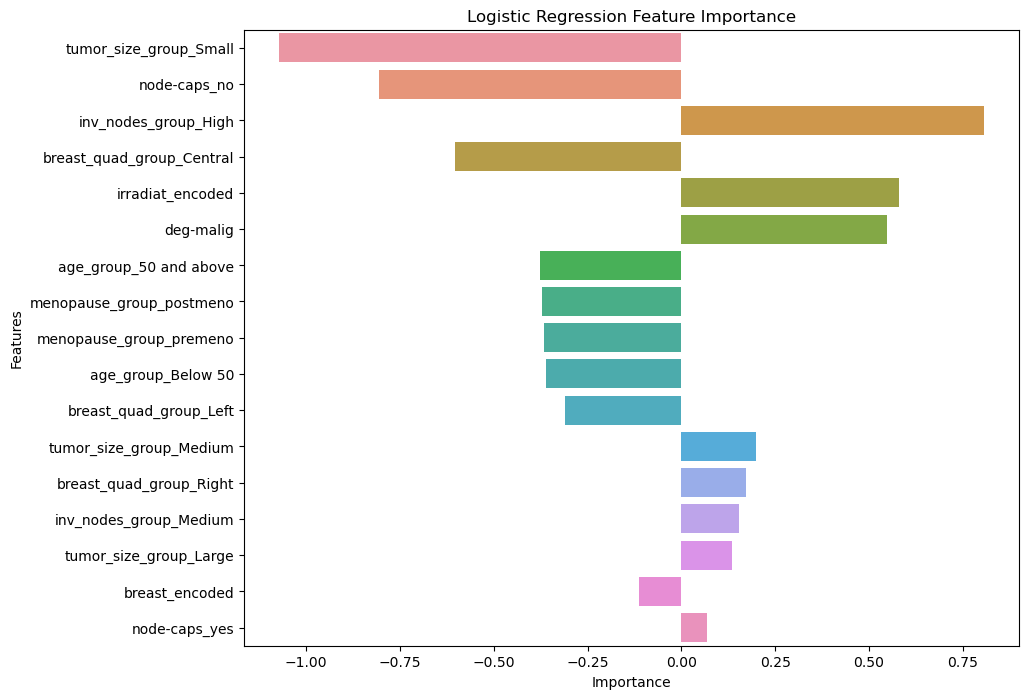

In [53]:
# Plot the feature importance
plt.figure(figsize = (10, 8))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_importance_lr_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.show()

**Findings:**
- Strong positive predictors of recurrence include receiving irradiation (irradiat), high lymph node involvement, and a higher degree of malignancy
- On the other hand, strong negative predictors of recurrence are smaller tumor size and absence of extracapsular extension

#### Decision Tree Feature Importance

In [54]:
features = X_train.columns 

# Create a DataFrame for feature importance extracted from Decision Tree model
feature_importance_dt_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances['Decision Tree']
}).sort_values(by = 'Importance', key = abs, ascending = False)

feature_importance_dt_df

,Feature,Importance
16,irradiat_encoded,0.133778
15,breast_encoded,0.125737
0,deg-malig,0.113778
13,breast_quad_group_Left,0.090003
8,inv_nodes_group_High,0.076845
1,age_group_50 and above,0.064527
6,tumor_size_group_Medium,0.062335
14,breast_quad_group_Right,0.052651
3,menopause_group_postmeno,0.046132
7,tumor_size_group_Small,0.041974


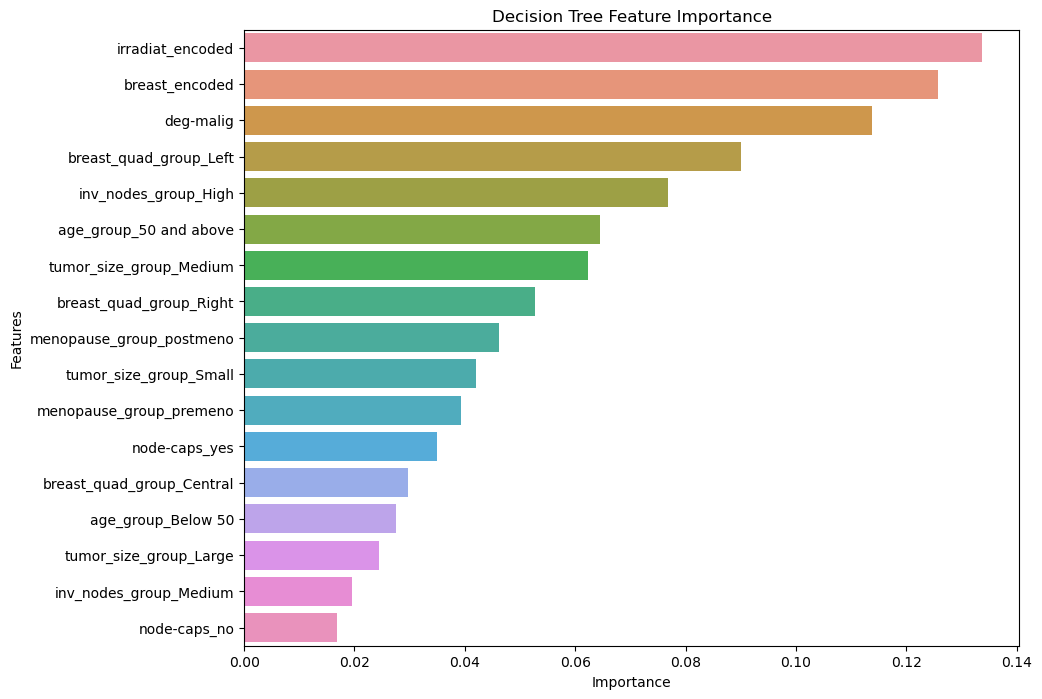

In [55]:
# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_importance_dt_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.show()

**Findings:**
- Location of cancer (left or right side) is the most significant factor
- Similar to findings in logistic regression model, other important predictors include receiving irradation, absence of extracapsular extension, degree of maglinancy.

## Summary of Key Findings

1. _Small Dataset Size_: The dataset contains only 286 samples which can significantly impact each model's ability to generalize well to unseen data. This limited size often leads to overfiting which we observed in the four models that were trained.


2. _Lack of significant improvement when using GridSearchCV_: Hyperparameter tuning with GridSearchCV did not yield substantial improvements in our model's performance. This is likely due to the model's inability to effectively learn from the small dataset. Among the models, KNeighbors and Support Vector Machines showed the most improvement in terms of recall on the test set.


3. _Feature importance_: Despite the models' suboptimal performance, we were still able to gain insights into which features are important for predicting recurrence. In Logistic Regression model, receiving irradiation, high lymph node involvement and a higher degree of malignancy were strong positive predictors. In the Decision Tree model, key predictors included tumor's location, receiving irradiation, absence of extracapsular extension, and the degree of malignancy. Patients with above-mentioned high risk features should be more closely monitored to detect recurrence early.




## Future Considerations

One of the biggest issues we encountered was that the models were unable to effectively learn from the small dataset. Therefore, I consider this a pilot study, as multiple improvements can be made. The following list are future considersations to take into account.

- Find a larger dataset to enable models to learn more effectively and generalize well to unseen data.
- Revisit hyperparameter tuning and data preprocessing steps to enhance cross-validation score and performance metrics.
- Incorporate genetic factors, such as genetic mutations and family history, as these can significantly increase risk of breast cancer.